In [1]:
#load packages
import os
import cv2
import natsort
import sys
import time
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from torchvision import transforms
from torch.utils.data import DataLoader
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score, f1_score
from sklearn.metrics import confusion_matrix

#custom library
dir_main = os.getcwd()
dir_model = str(Path(dir_main).parent)
sys.path.append(dir_model)
dir_file = str(Path(dir_main).parent.parent.parent)
sys.path.append(dir_file)
from CT_3D_onet_lib.library import *
from CT_3D_onet_lib.model import *

#set directory
dir_CT_3D_dataset = dir_model + '/CT_3D_onet_dataset'
dir_CT_3D_dataset_test = dir_CT_3D_dataset + '/test_result'
dir_Data_Train = str(Path(dir_main).parent.parent.parent) + '/Data/Train/'
ckpt_dir = os.path.join(dir_main, "checkpoint")
history_dir = os.path.join(dir_main, "history")

# Load Dataset

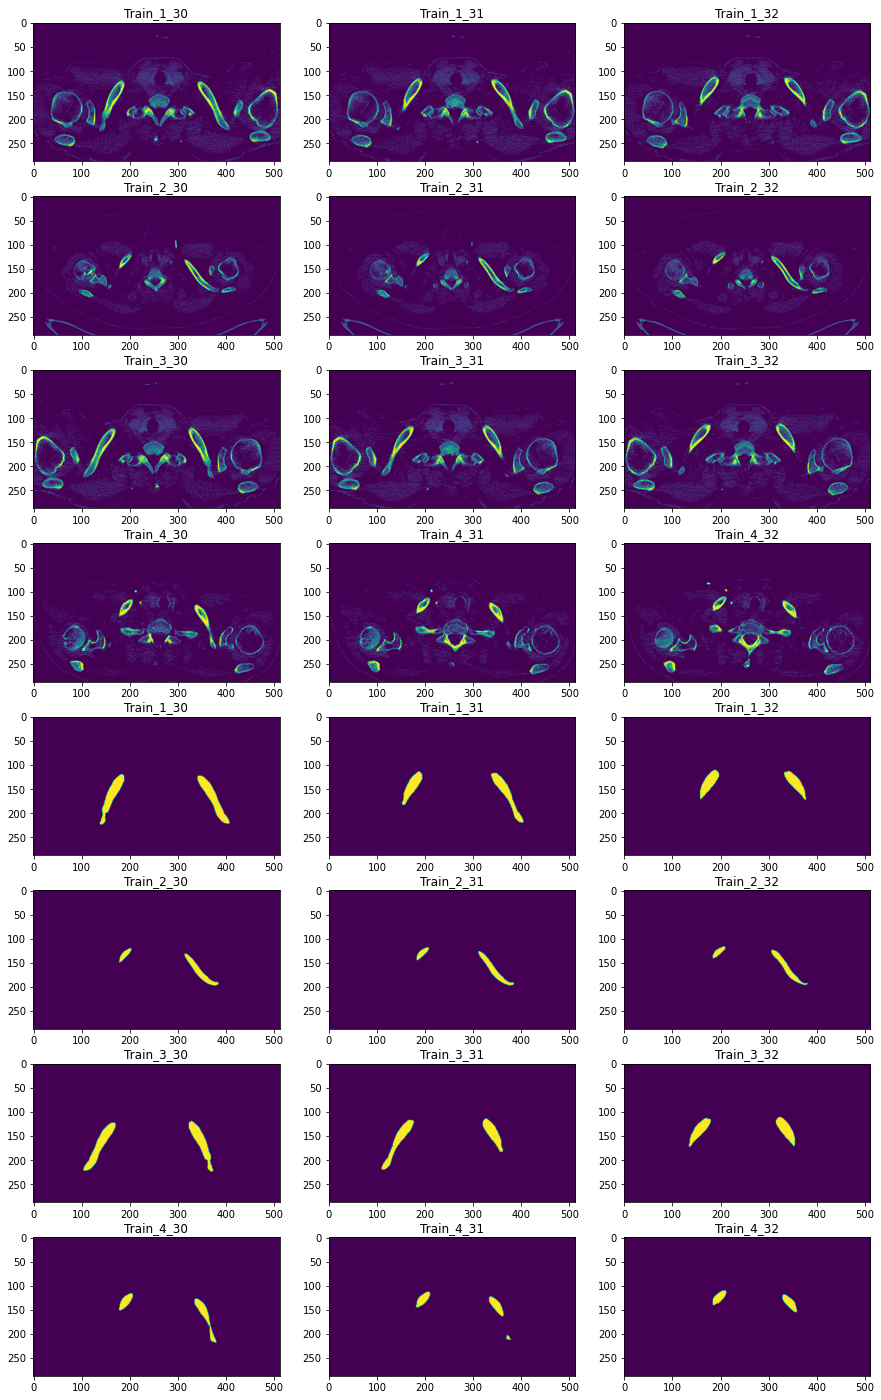

In [2]:
#load data
x_train, y_train, x_val, y_val, x_test, y_test = create_train_val_test(dir_Data_Train)

#visualize
num_plot = 1
fig = plt.figure(figsize=(15,25))
for i in range(x_train.shape[0]):
    if i==4:break
    for j in range(3):
        ax_x = fig.add_subplot(8, 3, num_plot)
        ax_x.imshow(x_train[i][30+j])
        ax_x.set_title('Train_{}_{}'.format(i+1,30+j))
        ax_y = fig.add_subplot(8, 3, num_plot+12)
        ax_y.imshow(y_train[i][30+j])
        ax_y.set_title('Train_{}_{}'.format(i+1,30+j))
        num_plot+=1
plt.show()

#save index
additional_process_3d(x_train, y_train, x_val, y_val, x_test, y_test)

#define boundary
concate_y_train = np.vstack((y_train,y_val,y_test))
patients_position = { 'start_z' : [], 'end_z' : []}
for i in range(len(concate_y_train)):
    triger = 0 
    bone_l, bone_r = split_bone(concate_y_train[i])
    for j in range(96):
        if np.sum(bone_l[j])!=0:
            if triger == 0:
                patients_position['start_z'].append(j+1)
                triger=1
        if np.sum(bone_l[j])==0:
            if triger == 1:
                patients_position['end_z'].append(j+1)
                triger=0
                break

#save datasets as .npy
for i in range(len(x_train)):
    np.save(os.path.join(dir_CT_3D_dataset+"/train", 'label_%03d.npy' % i), y_train[i])
    np.save(os.path.join(dir_CT_3D_dataset+"/train", 'input_%03d.npy' % i), x_train[i])

for i in range(len(x_test)):
    np.save(os.path.join(dir_CT_3D_dataset+"/test", 'label_%03d.npy' % i), y_test[i])
    np.save(os.path.join(dir_CT_3D_dataset+"/test", 'input_%03d.npy' % i), x_test[i])

for i in range(len(x_val)):
    np.save(os.path.join(dir_CT_3D_dataset+"/val", 'label_%03d.npy' % i), y_val[i])
    np.save(os.path.join(dir_CT_3D_dataset+"/val", 'input_%03d.npy' % i), x_val[i])

# Train

In [3]:
start = time.time()

# datasets
np_train_input_pool, np_train_label_pool = load_np_dataset("/train")
np_val_input_pool, np_val_label_pool = load_np_dataset("/val")
np_test_input_pool, np_test_label_pool = load_np_dataset("/test")
np_train_input = np_train_input_pool[:NUM_TRAIN]
np_train_label = np_train_label_pool[:NUM_TRAIN]
np_train_input_pool = np_train_input_pool[NUM_TRAIN:]
np_train_label_pool = np_train_label_pool[NUM_TRAIN:]
np_val_input = np_val_input_pool
np_val_label = np_val_label_pool
transform = transforms.Compose([Normalization(mean=0.5, std=0.5), ToTensor()])
dataset_train = labeled_Dataset_3D(np_train_input, np_train_label, transform=transform)
loader_train = DataLoader(dataset_train, batch_size=BATCH, shuffle=True, num_workers=0)
dataset_val = labeled_Dataset_3D(np_val_input, np_val_label, transform=transform)
loader_val = DataLoader(dataset_val, batch_size=BATCH, shuffle=False, num_workers=0)

# networks
device = torch.device('cpu')
onet = ONet_3D(UNet_3D).to(device)
models      = {'backbone': onet}

# optimization
optim_backbone = torch.optim.Adam(models['backbone'].parameters(), lr=LR)
optimizers = {'backbone': optim_backbone}

# loss function
fn_FT_Loss = FocalTverskyLoss().to(device)

# other
fn_tonumpy = lambda x: x.to('cpu').detach().numpy()
fn_denorm = lambda x, mean, std: (x * std) + mean
fn_class = lambda x: 1.0 * (x > 0.5)
num_data_train = len(dataset_train)
num_data_val = len(dataset_val)
num_batch_train = np.ceil(num_data_train / BATCH)
num_batch_val = np.ceil(num_data_val / BATCH)

# train
st_epoch = 0
models['backbone'], optimizers['backbone'], st_epoch = model_load(ckpt_dir=ckpt_dir, net=models['backbone'], optim=optimizers['backbone'])
total_train_backbone_loss = []
total_val_backbone_loss = []
for epoch in range(st_epoch + 1, EPOCH + 1):
    # train
    models['backbone'].train()
    train_backbone_loss = []
    for batch, data in enumerate(loader_train, 1):
        ## < load > ##
        label = data['label'].to(device)
        input = data['input'].to(device)
        ## < backbone > ##
        output = models['backbone'](input)
        optimizers['backbone'].zero_grad()
        backbone_loss = fn_FT_Loss.forward(output,label)
        backbone_loss.backward()
        ## < optimization > ##
        optimizers['backbone'].step()
        ## < history > ##
        train_backbone_loss += [backbone_loss.item()]
    total_train_backbone_loss += [np.mean(train_backbone_loss)]
    ## < print > ##
    print("TRAIN: EPOCH %04d / %04d | BATCH %04d / %04d | BackBoneLOSS %.4f " %
        (epoch, EPOCH, batch, num_batch_train, np.mean(train_backbone_loss)))

    # validation
    with torch.no_grad():
        models['backbone'].eval()
        val_backbone_loss = []
        for batch, data in enumerate(loader_val, 1):
            ## < load > ##
            label = data['label'].to(device)
            input = data['input'].to(device)
            ## < backbone > ##
            output = models['backbone'](input)
            backbone_loss = fn_FT_Loss.forward(output, label)
            ## < History > ##
            val_backbone_loss += [backbone_loss.item()]
        total_val_backbone_loss += [np.mean(val_backbone_loss)]
        ## < print > ##
        print("VALID: EPOCH %04d / %04d | BATCH %04d / %04d | BackBoneLOSS %.4f " %
            (epoch, EPOCH, batch, num_batch_val, np.mean(val_backbone_loss)))

    if epoch%20 == 0:
        ## < save > ##
        model_save(ckpt_dir=ckpt_dir, net=models['backbone'], optim=optimizers['backbone'], epoch=epoch)
        np.save(history_dir+"/train_loss_{}".format(epoch), total_train_backbone_loss)
        np.save(history_dir+"/val_loss_{}".format(epoch), total_val_backbone_loss)

print('Train Finish!')
print(f"{time.time()-start:.4f} sec")

Train Finish!
27.6342 sec


# Test

In [4]:
transform = transforms.Compose([Normalization(mean=0.5, std=0.5), ToTensor()])
dataset_test = Dataset(data_dir=os.path.join(dir_CT_3D_dataset, 'test'), transform=transform)
loader_test = DataLoader(dataset_test, batch_size=BATCH, shuffle=False, num_workers=0)
num_data_test = len(dataset_test)
num_batch_test = np.ceil(num_data_test / BATCH)
test_result_dir = os.path.join(dir_CT_3D_dataset, 'test_result')
if not os.path.exists(test_result_dir):
    os.makedirs(os.path.join(test_result_dir, 'png'))
    os.makedirs(os.path.join(test_result_dir, 'numpy'))
else:
      pass

models['backbone'], optimizers['backbone'], st_epoch = model_load(ckpt_dir=ckpt_dir, net=models['backbone'], optim=optimizers['backbone']) 
with torch.no_grad():
      models['backbone'].eval()
      loss_arr = []
      for batch, data in enumerate(loader_test, start=1):
          label = data['label'].to(device)
          input = data['input'].to(device)
          output = models['backbone'](input)
          loss=fn_FT_Loss.forward(output,label)
          loss_arr += [loss.item()]
          print("TEST: BATCH %04d / %04d | LOSS %.4f" %
                (batch, num_batch_test, np.mean(loss_arr)))
          label = fn_tonumpy(label)
          input = fn_tonumpy(fn_denorm(input, mean=0.5, std=0.5))
          output = fn_tonumpy(fn_class(output))
          if not os.path.exists(os.path.join(test_result_dir, 'png/batch_{}'.format(batch))):
            os.mkdir(os.path.join(test_result_dir, 'png/batch_{}'.format(batch)))
          for i in range(96):
                plt.imsave(os.path.join(test_result_dir, 'png/batch_{}'.format(batch), 'label_%04d.png' % i), label.reshape(96,288,512)[i], cmap='gray')
                plt.imsave(os.path.join(test_result_dir, 'png/batch_{}'.format(batch), 'input_%04d.png' % i), input.reshape(96,288,512)[i], cmap='gray')
                plt.imsave(os.path.join(test_result_dir, 'png/batch_{}'.format(batch), 'output_%04d.png' % i), output.reshape(96,288,512)[i], cmap='gray')
print("AVERAGE TEST: BATCH %04d / %04d | LOSS %.4f" %
        (batch, num_batch_test, np.mean(loss_arr)))


KeyboardInterrupt



# Result

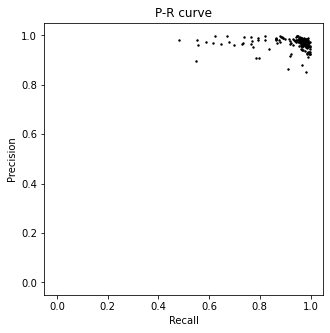


<Total Average>
Manual=> Total Precision: 0.970 Total Recall: 0.935 Total IoU: 0.909 Total DICE: 0.950


In [5]:
plt.figure(figsize=(5,5))

test_result_dir = dir_CT_3D_dataset_test
channel_of_test_patients= 4
lst_batch_dic_result = []
lst_total_socre_manual_precision=[]
lst_total_socre_manual_recall=[]
lst_total_socre_manual_iou=[]
lst_total_socre_manual_dice=[]
lst_total_socre_manual_confusion=[]

for nBatch in range(channel_of_test_patients):
    lst_data_png = os.listdir(test_result_dir + '/png/batch_{}'.format(nBatch+1))
    lst_label_png = [f for f in lst_data_png if f.startswith('label')]
    lst_output_png = [f for f in lst_data_png if f.startswith('output')]
    lst_label_png.sort()
    lst_output_png.sort()
    sum_iou=[]
    dic_result = {  'sum_manual_iou': [],
                    'sum_manual_dice': [],
                    'sum_manual_precision': [],
                    'sum_manual_recall': [],
                    'x_recall': [],
                    'x_precision': [],
                    'sum_skl_precision': [],
                    'sum_skl_recall': [],
                    'sum_skl_f1score': [],
                    'sum_tp': 0,
                    'sum_fn': 0,
                    'sum_fp': 0,
                    'sum_tn': 0   }

    for i in range(len(lst_label_png)):
        # ground_truth
        grd_truth = cv2.imread(test_result_dir + '/png/batch_{}/{}'.format(nBatch+1, lst_label_png[i]))
        grd_truth_gray = cv2.cvtColor(grd_truth, cv2.COLOR_BGR2GRAY)
        res, grd_truth_thr = cv2.threshold(grd_truth_gray, 127.5, 255, cv2.THRESH_BINARY)
        #masked
        masked = cv2.imread(test_result_dir + '/png/batch_{}/{}'.format(nBatch+1, lst_output_png[i]))
        masked_gray = cv2.cvtColor(masked, cv2.COLOR_BGR2GRAY)
        res, masked_thr = cv2.threshold(masked_gray, 127.5, 255, cv2.THRESH_BINARY)
        # intersection and union
        intersection = cv2.countNonZero(cv2.bitwise_and(grd_truth_thr, masked_thr))
        union = cv2.countNonZero(cv2.bitwise_or(grd_truth_thr,masked_thr))

        if np.sum(intersection)==0:
            continue

        #manual
        tp = cv2.bitwise_and(grd_truth_thr, masked_thr)
        fn = grd_truth_thr - tp
        fp = masked_thr - tp
        tn = np.invert(cv2.bitwise_or(grd_truth_thr,masked_thr)) +2

        tp_count = cv2.countNonZero(cv2.bitwise_and(grd_truth_thr, masked_thr))
        fn_count = cv2.countNonZero(grd_truth_thr - tp)
        fp_count = cv2.countNonZero(masked_thr - tp)
        tn_count = cv2.countNonZero(np.invert(cv2.bitwise_or(grd_truth_thr,masked_thr)) +2)

        iou_test = tp_count /(tp_count+fp_count+fn_count)
        dice_test = 2*tp_count / ((tp_count + fn_count) + (tp_count + fp_count))
        precision_test = tp_count / (tp_count + fp_count) 
        recall_test = tp_count / (tp_count + fn_count)

        dic_result['sum_manual_iou'].append(iou_test)
        dic_result['sum_manual_dice'].append(dice_test)
        dic_result['sum_manual_precision'].append(precision_test)
        dic_result['sum_manual_recall'].append(recall_test)
        dic_result['x_recall'].append(i)
        dic_result['x_precision'].append(i)

        #sklearn
        y_true = grd_truth_thr
        y_pred = masked_thr
        dic_result['sum_skl_precision'].append(precision_score(y_true,y_pred, average='micro'))
        dic_result['sum_skl_recall'].append(recall_score(y_true, y_pred, average='micro'))
        dic_result['sum_skl_f1score'].append(f1_score(y_true,y_pred, average='micro'))

        dic_result['sum_tp'] += tp_count
        dic_result['sum_fn'] += fn_count
        dic_result['sum_fp'] += fp_count
        dic_result['sum_tn'] += tn_count

    lst_batch_dic_result.append(dic_result)

    #result
    result_iou = np.sum(dic_result['sum_manual_iou']) / len(dic_result['sum_manual_iou'])
    result_dice = np.sum(dic_result['sum_manual_dice']) / len(dic_result['sum_manual_dice'])
    result_precision = np.sum(dic_result['sum_manual_precision']) / len(dic_result['sum_manual_precision'])
    result_recall = np.sum(dic_result['sum_manual_recall']) / len(dic_result['sum_manual_recall'])
    result_skl_precision = np.sum(dic_result['sum_skl_precision']) / len(dic_result['sum_skl_precision'])
    result_skl_recall = np.sum(dic_result['sum_skl_recall']) / len(dic_result['sum_skl_recall'])
    result_skl_f1score = np.sum(dic_result['sum_skl_f1score']) / len(dic_result['sum_skl_f1score'])

    #total result
    lst_total_socre_manual_precision.append(result_precision)
    lst_total_socre_manual_recall.append(result_recall)
    lst_total_socre_manual_iou.append(result_iou)
    lst_total_socre_manual_dice.append(result_dice)
    lst_total_socre_manual_confusion.append(dic_result)

    plt.subplot(111)
    plt.title('P-R curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.xlim([-0.05,1.05])
    plt.ylim([-0.05,1.05])
    plt.scatter(dic_result['sum_manual_recall'], dic_result['sum_manual_precision'], s=2, color ='black')
plt.show()

#total result average print
total_result_iou = np.sum(lst_total_socre_manual_iou) / len(lst_total_socre_manual_iou)
total_result_dice = np.sum(lst_total_socre_manual_dice) / len(lst_total_socre_manual_dice)
total_result_precision = np.sum(lst_total_socre_manual_precision) / len(lst_total_socre_manual_precision)
total_result_recall = np.sum(lst_total_socre_manual_recall) / len(lst_total_socre_manual_recall)

print()
print('<Total Average>')
print('Manual=>','Total Precision: %.3f' % total_result_precision,'Total Recall: %.3f' % total_result_recall,'Total IoU: %.3f' % total_result_iou,'Total DICE: %.3f' % total_result_dice)

np_test_inx = np.load(dir_CT_3D_dataset + '/index/test_inx.npy')
total_len = []
for num_test_patient in range(4):
    test_i = [i for i in range(len(np_test_inx)) if np_test_inx[i]>=96*(num_test_patient) and np_test_inx[i]<96*(num_test_patient+1) ]
    test_len = 96-len(np_test_inx[test_i])
    total_len.append(test_len)
y_plot_recall = []
y_plot_precision = []
for i in range(len(lst_batch_dic_result)):
    y_plot_recall += lst_batch_dic_result[i]['sum_manual_recall']
    y_plot_precision += lst_batch_dic_result[i]['sum_manual_precision']

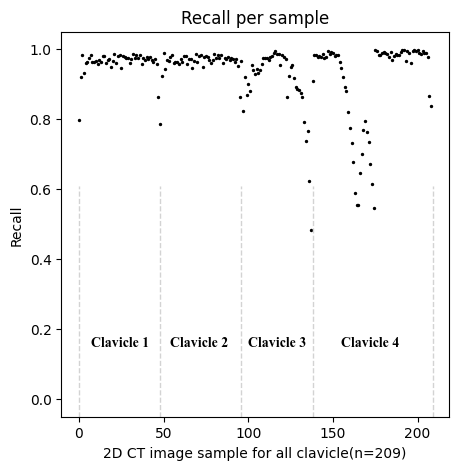

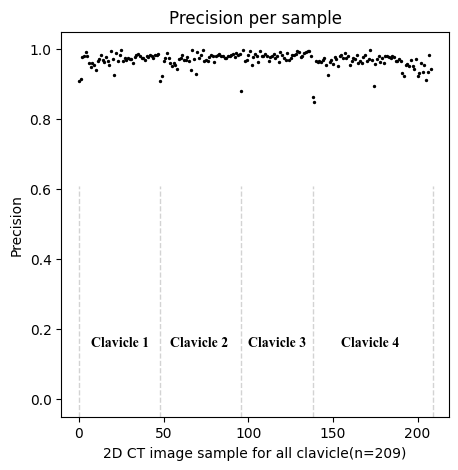

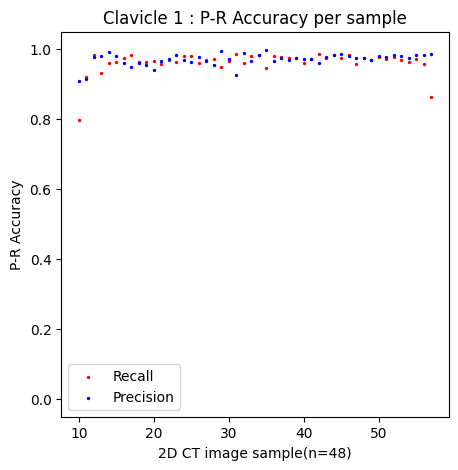

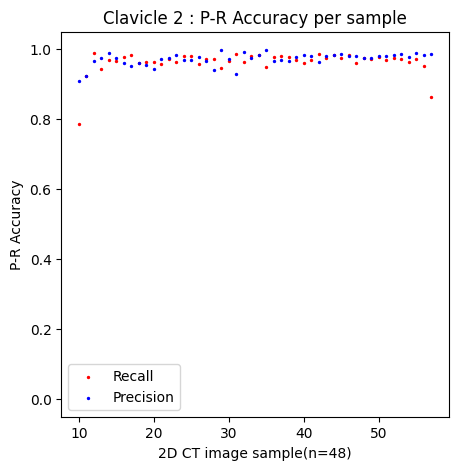

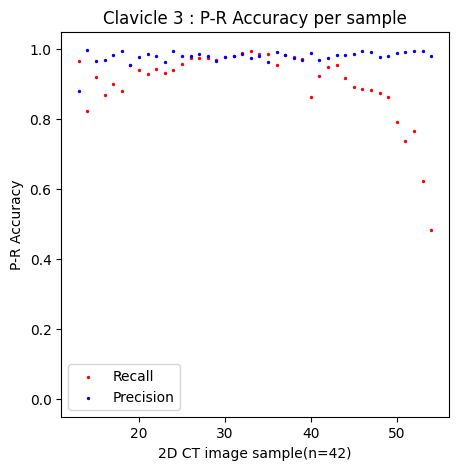

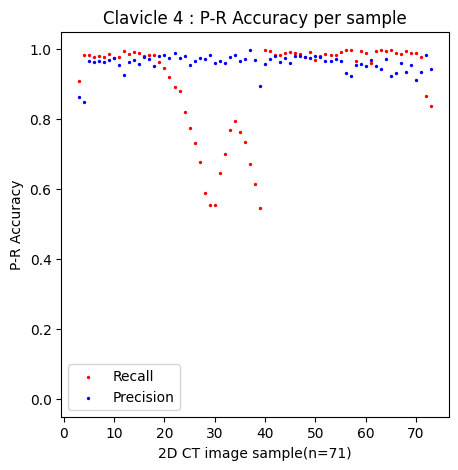

In [16]:
font2 = {'family': 'Times New Roman',
      'color':  'black',
      'weight': 'bold',
      'size': 10,
      'alpha': 1.0}

plt.figure(figsize=(5,5))
plt.title('Recall per sample')
plt.xlabel('2D CT image sample for all clavicle(n=209)')
plt.ylabel('Recall')
plt.ylim([-0.05,1.05])
plt.scatter(x=list(range(np.sum(total_len)))  ,   y=y_plot_recall, s=2, color ='black')
plt.text(7, 0.15, 'Clavicle 1', fontdict=font2)
plt.text(54, 0.15, 'Clavicle 2', fontdict=font2)
plt.text(100, 0.15, 'Clavicle 3', fontdict=font2)
plt.text(155, 0.15, 'Clavicle 4', fontdict=font2)
plt.axvline(0, 0.0, 0.6, color='lightgray', linestyle='--', linewidth=1)
plt.axvline(total_len[0], 0.0, 0.6, color='lightgray', linestyle='--', linewidth=1)
plt.axvline(total_len[0]+total_len[1], 0.0, 0.6, color='lightgray', linestyle='--', linewidth=1)
plt.axvline(total_len[0]+total_len[1]+total_len[2], 0.0, 0.6, color='lightgray', linestyle='--', linewidth=1)
plt.axvline(total_len[0]+total_len[1]+total_len[2]+total_len[3], 0.0, 0.6, color='lightgray', linestyle='--', linewidth=1)
plt.show()

plt.figure(figsize=(5,5))
plt.title('Precision per sample')
plt.xlabel('2D CT image sample for all clavicle(n=209)')
plt.ylabel('Precision')
plt.ylim([-0.05,1.05])
plt.scatter(x=list(range(np.sum(total_len)))  ,y=y_plot_precision, s=2, color ='black')
plt.text(7, 0.15, 'Clavicle 1', fontdict=font2)
plt.text(54, 0.15, 'Clavicle 2', fontdict=font2)
plt.text(100, 0.15, 'Clavicle 3', fontdict=font2)
plt.text(155, 0.15, 'Clavicle 4', fontdict=font2)
plt.axvline(0, 0.0, 0.6, color='lightgray', linestyle='--', linewidth=1)
plt.axvline(total_len[0], 0.0, 0.6, color='lightgray', linestyle='--', linewidth=1)
plt.axvline(total_len[0]+total_len[1], 0.0, 0.6, color='lightgray', linestyle='--', linewidth=1)
plt.axvline(total_len[0]+total_len[1]+total_len[2], 0.0, 0.6, color='lightgray', linestyle='--', linewidth=1)
plt.axvline(total_len[0]+total_len[1]+total_len[2]+total_len[3], 0.0, 0.6, color='lightgray', linestyle='--', linewidth=1)
plt.show()

if len(lst_batch_dic_result) == len(total_len):
    for i in range(len(total_len)):
        plt.figure(figsize=(5,5))
        plt.title('Clavicle {} : P-R Accuracy per sample'.format(i+1))
        plt.xlabel('2D CT image sample(n={})'.format(total_len[i]))
        plt.ylabel('P-R Accuracy')
        plt.ylim([-0.05,1.05])
        plt.scatter(x=lst_batch_dic_result[i]['x_recall']  ,   y=lst_batch_dic_result[i]['sum_manual_recall'], s=2, color='red', label='Recall')
        plt.scatter(x=lst_batch_dic_result[i]['x_precision']  ,   y=lst_batch_dic_result[i]['sum_manual_precision'], s=2, color='blue', label='Precision')
        plt.legend()
        plt.show()

In [14]:
#Precision with minimum
print('Precision with minimum:')
for i in range(len(total_len)):
    print('Clavicle {}:'.format(i), np.min(lst_batch_dic_result[i]['sum_manual_precision']))
print()
print('Recall with minimum:')
#recall with minimum
for i in range(len(total_len)):
    print('Clavicle {}:'.format(i), np.min(lst_batch_dic_result[i]['sum_manual_recall']))


Precision with minimum:
Clavicle 0: 0.9102564102564102
Clavicle 1: 0.9090909090909091
Clavicle 2: 0.8809523809523809
Clavicle 3: 0.8503086419753086

Recall with minimum:
Clavicle 0: 0.797752808988764
Clavicle 1: 0.7865168539325843
Clavicle 2: 0.48214285714285715
Clavicle 3: 0.5466237942122186
